In [2]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchviz import make_dot
from torch.utils.data import Dataset, DataLoader

In [3]:
def img_to_array(img, data_format=None, dtype=None):
    """Converts a PIL Image instance to a Numpy array.

    Usage:

    ```python
    from PIL import Image
    img_data = np.random.random(size=(100, 100, 3))
    img = tf.keras.utils.array_to_img(img_data)
    array = tf.keras.utils.image.img_to_array(img)
    ```


    Args:
        img: Input PIL Image instance.
        data_format: Image data format, can be either `"channels_first"` or
          `"channels_last"`. None means the global
          setting `tf.keras.backend.image_data_format()` is used (unless you
          changed it, it uses `"channels_last"`). Defaults to `None`.
        dtype: Dtype to use. None makes the global setting
          `tf.keras.backend.floatx()` to be used (unless you changed it, it
          uses `"float32"`). Defaults to `None`.

    Returns:
        A 3D Numpy array.

    Raises:
        ValueError: if invalid `img` or `data_format` is passed.
    """
    # Numpy array x has format (height, width, channel)
    # or (channel, height, width)
    # but original PIL image has format (width, height, channel)
    x = np.asarray(img, dtype=dtype)
    if len(x.shape) == 3:
        if data_format == "channels_first":
            x = x.transpose(2, 0, 1)
    elif len(x.shape) == 2:
        if data_format == "channels_first":
            x = x.reshape((1, x.shape[0], x.shape[1]))
        else:
            x = x.reshape((x.shape[0], x.shape[1], 1))
    else:
        raise ValueError(f"Unsupported image shape: {x.shape}")
    return x

In [4]:
train_high = "../lol_dataset/our485/high"
train_low = "../lol_dataset/our485/low"

test_high = "../lol_dataset/eval15/high"
test_low = "../lol_dataset/eval15/low"

SIZE = 256

In [5]:
def load_images(path, augment=True):
    x = []
    image_paths = []
    for imageDir in os.listdir(path):
      img_path = os.path.join(path, imageDir)
      image_paths.append(img_path)
    image_paths.sort()
    for img_path in image_paths:
        img = cv.imread(img_path,1)
        if img is None:
            continue
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        img = cv.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        x.append(img_to_array(img, data_format="channels_first"))

        if augment:
            # performing data augmentation by rotating, and flipping the image
            img1 = cv.flip(img,1)
            x.append(img_to_array(img1, data_format="channels_first"))

            img2 = cv.flip(img,-1)
            x.append(img_to_array(img2, data_format="channels_first"))

            img3 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)
            x.append(img_to_array(img3, data_format="channels_first"))

            img4 = cv.rotate(img, cv.ROTATE_90_COUNTERCLOCKWISE)
            x.append(img_to_array(img4, data_format="channels_first"))

    return x

In [6]:
x_train = load_images(train_low)
y_train = load_images(train_high)

x_test = load_images(test_low, augment=False)
y_test = load_images(test_high, augment=False)

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

# Keras is channels last, whereas pytorch was channel first

2425
2425
15
15


In [7]:
def plot_images(image, ground_truth):
    plt.figure(figsize=(7,7))
    plt.subplot(1,2,1)
    plt.title('Image', color = 'green', fontsize = 10)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.imshow(ground_truth)

    plt.show()

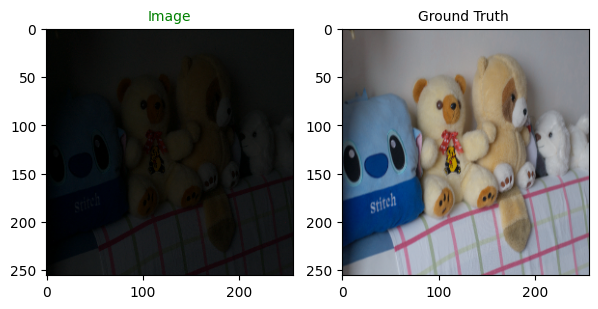

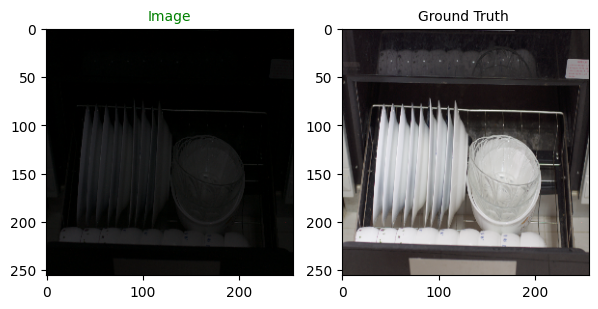

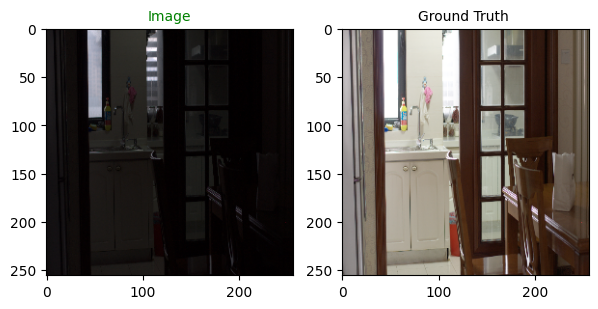

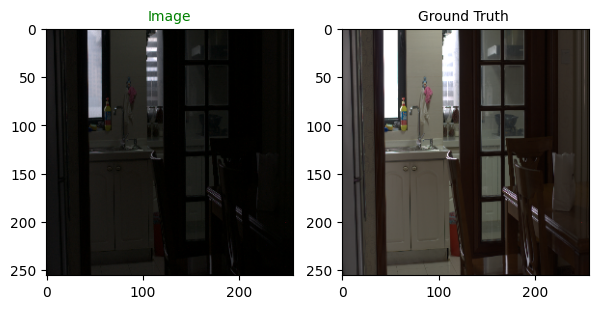

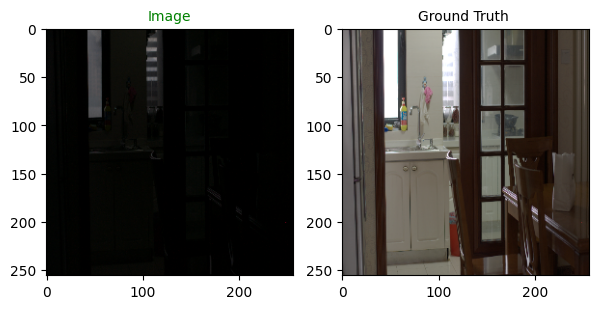

In [8]:
for i in range(0,25,5):
    plot_images(x_train[i].transpose(1, 2, 0),y_train[i].transpose(1, 2, 0))

In [9]:
class Downsample(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, apply_batch_normalization=True):
        super(Downsample, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
        self.apply_batch_normalization = apply_batch_normalization
        if apply_batch_normalization:
            self.batch_norm = nn.BatchNorm2d(filters)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv(x)
        if self.apply_batch_normalization:
            x = self.batch_norm(x)
        x = self.leaky_relu(x)
        return x


In [10]:
class Upsample(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, dropout=False):
        super(Upsample, self).__init__()
        self.conv_transpose = nn.ConvTranspose2d(in_channels=in_channels, out_channels=filters, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
        self.dropout = dropout
        if dropout:
            self.dropout_layer = nn.Dropout2d(p=0.1)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        x = self.conv_transpose(x, output_size=(x.size(0), x.size(1), x.size(2) * 2, x.size(3) * 2))
        if self.dropout:
            x = self.dropout_layer(x)
        x = self.leaky_relu(x)
        return x

In [11]:
class Model(nn.Module):
    def __init__(self, kernel=3):
        super(Model, self).__init__()
        self.down1 = Downsample(in_channels=3, filters=128, kernel_size=kernel, apply_batch_normalization=False)
        self.down2 = Downsample(in_channels=128, filters=256, kernel_size=kernel, apply_batch_normalization=False)
        self.down3 = Downsample(in_channels=256, filters=512, kernel_size=kernel, apply_batch_normalization=True)
        self.down4 = Downsample(in_channels=512, filters=512, kernel_size=kernel, apply_batch_normalization=True)

        self.up1 = Upsample(in_channels=512, filters=512, kernel_size=kernel, dropout=True)
        self.up2 = Upsample(in_channels=1024, filters=256, kernel_size=kernel, dropout=True)
        self.up3 = Upsample(in_channels=512, filters=128, kernel_size=kernel, dropout=True)
        self.up4 = Upsample(in_channels=256, filters=3, kernel_size=kernel, dropout=True)

        self.final_conv = nn.Conv2d(6, 3, kernel_size=(2, 2), stride=1, padding="same")

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        r = self.down4(d3)
        
        u1 = self.up1(r)
        u1 = torch.cat([u1, d3], dim=1)
        u2 = self.up2(u1)
        u2 = torch.cat([u2, d2], dim=1)
        u3 = self.up3(u2)
        u3 = torch.cat([u3, d1], dim=1)
        u4 = self.up4(u3)
        u4 = torch.cat([u4, x], dim=1)

        output = self.final_conv(u4)
        
        return output

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Model(kernel=5)
model= nn.DataParallel(model)
model.to(device)

DataParallel(
  (module): Model(
    (down1): Downsample(
      (conv): Conv2d(3, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (down2): Downsample(
      (conv): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (down3): Downsample(
      (conv): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (down4): Downsample(
      (conv): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
      (batch_norm): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (leaky_relu): LeakyReLU(negative_slope=0.01)
    )
    (up1): Upsample(
      (conv_transpose): ConvTranspose2d(512, 512, kernel_size=(5, 5), stride=(2, 2), paddi

In [13]:
class LLEDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]
    
train_dataset = LLEDataset(x_train, y_train)
test_dataset = LLEDataset(x_test, y_test)
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

## Plot the model image for report

In [14]:
# batch = next(iter(train_loader))
# yhat = model(batch[0].to(device))
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("LLEModel_torchviz", format="png")

## Training Loop

In [15]:
torch.cuda.empty_cache()

In [19]:
epochs = 100
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_losses = []
test_losses = []
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            x, y = batch
            x = x.to(device)
            y = y.to(device)
            yhat = model(x)
            loss = criterion(yhat, y)
            test_loss += loss.item()
        test_loss /= len(test_loader)
        test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss}, Test Loss: {test_loss}")

/DATA/sujit_2021cs35/anaconda3/envs/cv/lib/python3.9/site-packages/torch/nn/modules/conv.py:459: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1003.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 1/100, Train Loss: 0.45138895825335856, Test Loss: 0.32797467708587646


KeyboardInterrupt: 

## Save the model weights

In [ ]:
# Specify the file path to save the weights
weights_path = 'model_weights.pth'

# Save the model's state_dict
torch.save(model.state_dict(), weights_path)

## Load the model weights

In [16]:
model.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

In [17]:
def plot_images(image,ground_truth,predicted):
    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.title('Image', color = 'green', fontsize = 10)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.title('Ground Truth ', color = 'black', fontsize = 10)
    plt.imshow(ground_truth)
    plt.subplot(1,3,3)
    plt.title('Enhanced ', color = 'Red', fontsize = 10)
    plt.imshow(predicted)

    plt.show()

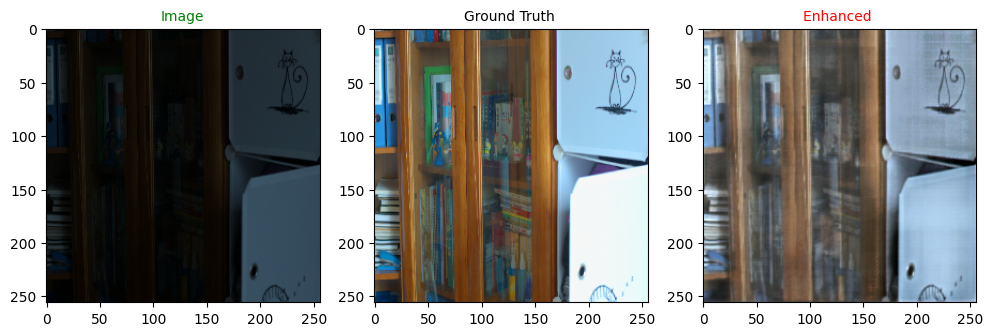

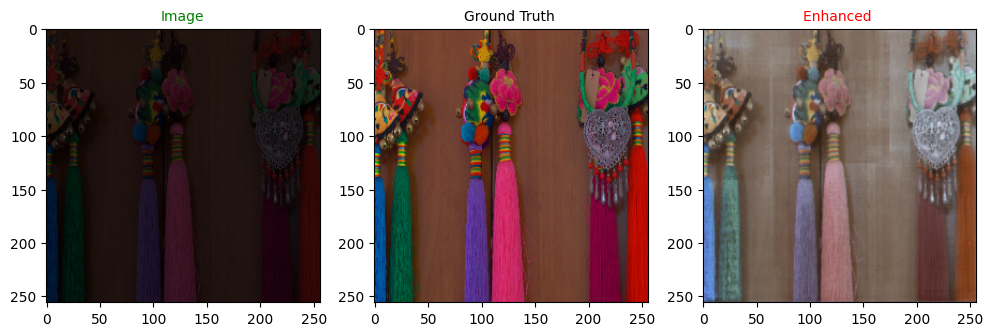

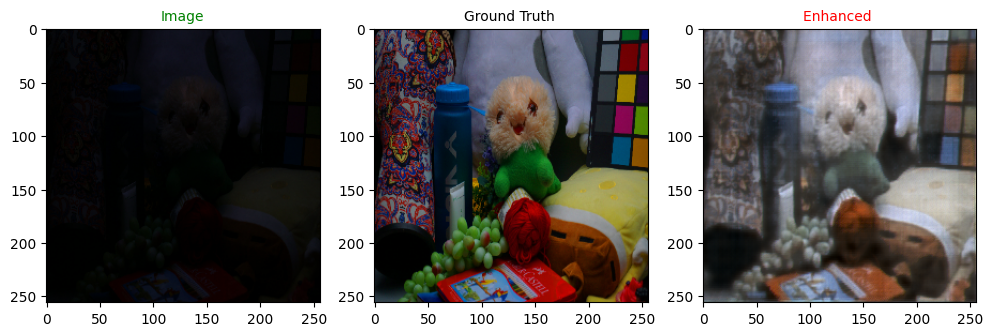

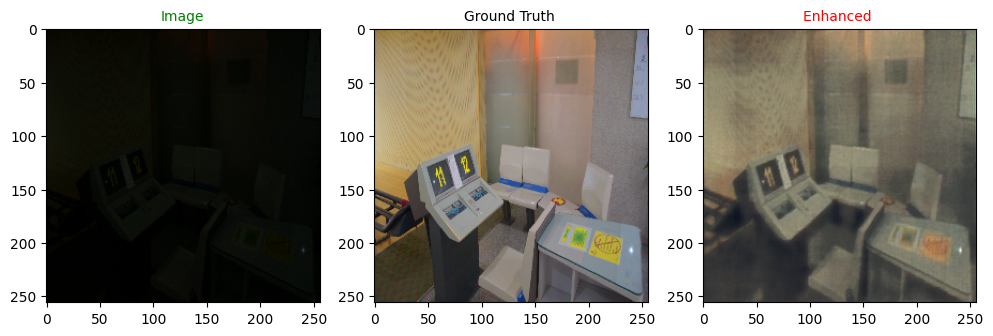

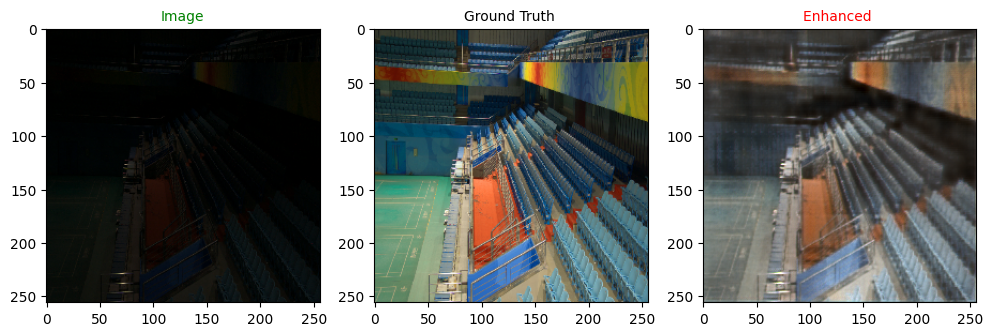

In [21]:
for i in range(0,len(x_test), 3):
    input_img = torch.tensor(x_test[i]).unsqueeze(0).to(device)
    yhat = model(input_img).cpu().detach().numpy()
    predicted = np.clip(yhat,0.0,1.0)
    plot_images(x_test[i].transpose(1, 2, 0),y_test[i].transpose(1, 2, 0),predicted.squeeze(0).transpose(1, 2, 0))

In [22]:
def plot_figure(images: list, titles: list, rows: int, columns: int, fig_width=15, fig_height=7):
    fig = plt.figure(figsize=(fig_width, fig_height))
    count = 1
    for image, title in zip(images, titles):
        fig.add_subplot(rows, columns, count)
        count += 1
        plt.imshow(image, 'gray')
        plt.axis('off')
        plt.title(title)

## Trying on real life images

In [23]:
# resize the images to SIZExSIZE
dir = './test_img/'
resize_dir = './test_img_resized/'
image_names = os.listdir(dir)
for img_name in image_names:
    img = cv.imread(dir + img_name, 1)
    img = cv.resize(img, (SIZE, SIZE))
    cv.imwrite(resize_dir + img_name, img)

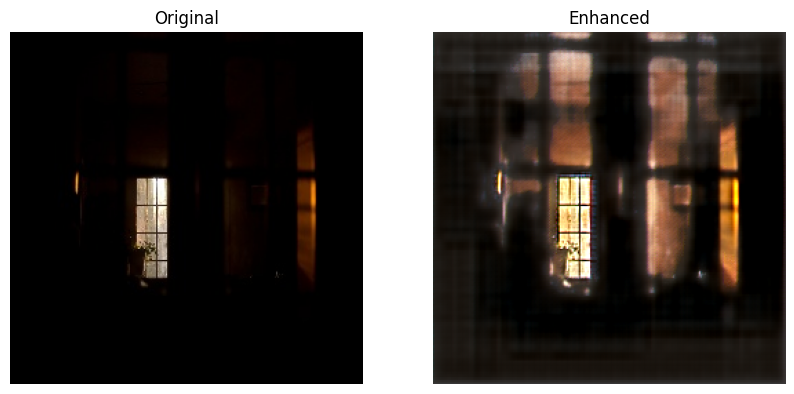

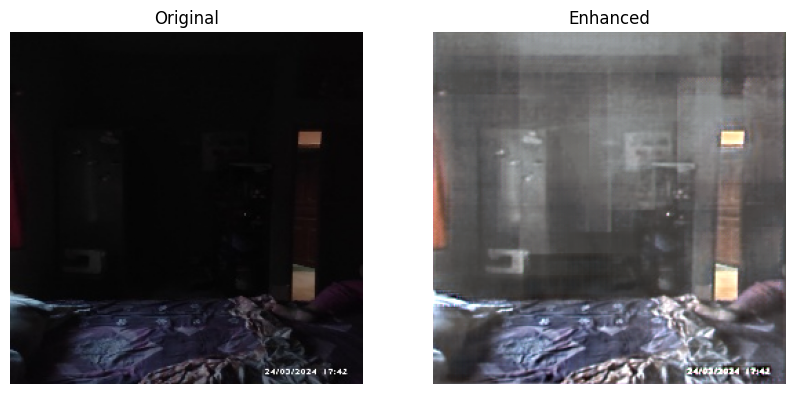

In [40]:
test_dir = './test_img_resized/'
test_x = load_images(test_dir, augment=False)

# pass the image through the model and save the output
for i in range(len(test_x)):
    input_img = torch.tensor(test_x[i]).unsqueeze(0).to(device)
    yhat = model(input_img).cpu().detach().numpy()
    predicted = np.clip(yhat,0.0,1.0)
    plt.imsave(f'./output_img/{i}.png', predicted.squeeze(0).transpose(1, 2, 0))
    
    # plot original and enhanced image
    plot_figure([test_x[i].transpose(1, 2, 0), predicted.squeeze(0).transpose(1, 2, 0)], ['Original', 'Enhanced'], 1, 2, 10, 5)

In [37]:
def enhance(image_path, out):
    SIZE = 256
    img = cv.imread(image_path, 1)
    img_resize = cv.resize(img, (SIZE, SIZE))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Model(kernel=5)
    model= nn.DataParallel(model)
    model.to(device)
    inp = torch.tensor(img_resize.transpose(2,0,1)).unsqueeze(0).to(device).float()
    yhat = model(inp).cpu().detach().numpy()
    enhanced = np.clip(yhat,0.0,1.0)
    plt.imsave(f'./result/{out}.png', enhanced.squeeze(0).transpose(1, 2, 0))

In [38]:
enhance('./Low_light.jpg', out='op')

torch.Size([1, 3, 256, 256])
